In [0]:
# Author: Max Mowbray, PhD Candidate, University of Manchester
# importing relevant python packages and declaring reference notation
import numpy as np
import pandas as pd
import scipy.integrate as scp
import matplotlib.pyplot as plt
import numpy.random as rnd
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
eps  = np.finfo(float).eps
import csv

The aim of this workbook is to provide a walk through of the programming behind applying reinforcement learning algorithms to discrete problems. 

Firstly, we will consider a simple continuous fermentation problem. The states defining the system are simply Biomass, $X$ and Nitrate, $N$ concentrations. This dynamic system can be described as:

$$\frac{\text{d}x}{\text{d}t}=\mu~x~\frac{N}{N+K_N}-\mu_d~x^2$$ 

$$\frac{\text{d}N}{\text{d}t}=-Y_{N/x}~\mu~\frac{N}{N+K_N}x+F_{N_{in}}$$

In this case, the control available to the agent is purely desribed the nitrate inflow rate $$F_{N_{in}}\in[0,7]$$

This means the nitrate inflow rate can take any value in the range [0,7] $mg/h$ (please note units, $X$ $g/L$ and $N$ $mg/L$). However, intially we want to limit the number of state-action pairs for the sake of computational intensity - hence may only allow values that are factors of $0.5$...

In the case of tabular implementation, we discretise the system and structure the state space on a grid of 'acceptable' state values. Therefore, we implement a rounding policy to round the 'real' system values to those accepted (the real state values are those observed after integration of the system of ODEs described over one time step). We may introduce stochasticity (randomness) into our system via a stochastic rounding policy (see discrete_env method).

However, for an agent to learn we must define some objective function for our system. One such objective function may act to reduce the waste in the system at the end of the run, whilst maximising biomass concentration (or more succinctly, as maximisation of productivity)

$$f_{obj_1}=100x_{t_f}-N_{t_f}$$

We may explore a range of objective functions and develop complexity as the work progresses

So our first steps are to define the system we wish to train our agent with as well as the rounding policy. Here we may make use of python's object-oriented programming paradigm:


In [0]:
class Model_env: 
    
    # --- initializing model --- #
    def __init__(self, parameters, steps, tf, x0, modulus):
        
        # Object variable definitions
        self.parameters, self.steps = parameters, steps
        self.x0, self.dt, self.tf      = x0, tf/steps, tf                
        self.modulus                   = modulus          # two column array [biomass nitrate ]
        
    # --- dynamic model definition --- #    
    # model takes state and action of previous time step and integrates -- definition of ODE system at time, t
    def model(self, t, state, control):
        # internal definitions
        params = self.parameters
        FCn   = control
                
        # state vector
        Cx  = state[0]
        Cn  = state[1]
        
        # parameters
        u_m  = params['u_m']; K_N  = params['K_N'];
        u_d  = params['u_d']; Y_nx = params['Y_nx'];
        
        # algebraic equations
        
        # variable rate equations
        dev_Cx  = u_m * Cx * Cn/(Cn+K_N) - u_d*Cx**2
        dev_Cn  = - Y_nx * u_m * Cx * Cn/(Cn+K_N) + FCn
        
        return np.array([dev_Cx, dev_Cn],dtype='float64')
    
    def discrete_env(self, state):
        # discretisation of the system, with introduction of stochasticity in terms of modulus
        modulus = self.modulus
        
            
        resid = state % modulus
        resid = resid/modulus
        UB = 1 - resid
        draw =  np.ones(2)

        for i in range(state.shape[0]):
            if draw[i] < UB[i]:
              state[i] = state[i] - resid[i] * modulus[i]
            else:
              state[i] = state[i] - resid[i] * modulus[i] + modulus[i]
        
        # fixes for representation 
        # Nitrate 
        if state[1] < 0:
          state[1] = 0
        elif state[1] < self.modulus[1]/2:
          state[1] = 0
        
        # Biomass
        f = str(self.modulus[0])
        decimal = f[::-1].find('.')  
        state[0] = np.round(state[0], decimal)
        
        return state

    def reward(self, state):
      reward = 100*state[-1][0] - state[-1][1]              # objective function 1
      return reward

Note the syntax of the reward allocation. It is based on the final state values. Therefore, we will have to reallocate the reward to actions taken within a sequence after the run. 

Next we may define the agent. Conventionally, the agent observes the state ($S_{t}$) and interacts with the environment at time $t$ via some action ($A_{t}$), receives feedback about the quality of the action ($R_{t+1}$) and the next state of the environment ($S_{t+1}$).

However, in this case the agent will only receive reward at the terminal time, $T$. Therefore, we must devise an appropriate back allocation policy, in order for the agent to learn the value of each action. This is otherwise known as temporal credit assignment and is a key factor in developing solid reinforcement learning algorithms and ultimately agents. Initially we will try

$$R_{t+1}=R_{T}~\gamma_{1}^2$$
$$\gamma_{1}\in[0,1]$$

Here $\gamma_{1}$ is some discount factor that determines how we value actions later in the sequence relative to actions earlier in the sequence. This may be a parameter for investigation during the training of an efficacious agent.

The agent defined below is based on Monte Carlo Learning, which relies on large state space sweeps, experience of playing actions and updating the expected return $G_{t}$ from that state-action, ($s,a$) pair.

We may define the expected return from a ($s,a$) pair recursively as:

$$G_{t} = R_{t+1} + \gamma_{2}~R_{t+2}+ \gamma_{2}^{2}~R_{t+3} + ... +\gamma_{2}^{T-1}R_{T}$$
$$$$
$$G_{t} = R_{t+1} + \gamma_{2}~G_{t+1}$$

$$$$
$$\gamma_{2} \in [0,1] $$

Where $\gamma_{2}$ is a discount factor that signifies how an agent values immediate reward over future return. Note the state-action value represents the expected return $G_{t}$ from choosing an action, $A_{t}$ in a given state, $S_{t}$.

Make sure to understand the initialisation of the $(s,a)$ dictionary as well as the count (under the _init_ method). Later, we will replace the $(s,a)$ dictionary with a function approximator (such as neural network).


In [0]:
############# Defining Agent To Be Trained ##################
class greedye_MCL:
    def __init__(self, num_actions, modulus, state_UB, disc1, disc2, movements):
      self.name = "e-Greedy"
      # defining number of actions available to agent, the line distance of the state space, the upper bound of the state space and the number of s-a pairs observed per sequence (from t = 0...T)
      self.num_actions, self.modulus, self.UB, self.movements  = num_actions, modulus, state_UB, movements    
      self.disc1, self.disc2 = disc1, disc2                                                                       # defining discount factors
      self.X_s = np.linspace(0, int(self.UB[0]), int(self.UB[0]/self.modulus[0] + 1), dtype = np.float64)
      self.N_s = np.linspace(0, int(self.UB[1]), int(self.UB[1]/self.modulus[1] + 1), dtype = np.float64)
      f1, f2   = str(self.modulus[0]), str(self.modulus[1])
      decimal1, decimal2 = f1[::-1].find('.'), f2[::-1].find('.')                                           
      # defining state-action value dictionary based on grid definition from X_s and N_s
      self.d = {(X_si, N_si, ti): np.random.randn(num_actions) for X_si in np.round(self.X_s,decimal1) for N_si in np.round(self.N_s,decimal2) for ti in np.arange(1,self.movements+1, dtype ="int")}
      # initialising count for observation of each state-action pair
      self.dcount = {(X_si, N_si, ti): np.zeros(num_actions) for X_si in np.round(self.X_s,decimal1) for N_si in np.round(self.N_s,decimal2) for ti in np.arange(1,self.movements+1, dtype ="int")}
     
    def act(self,state, eps_prob, s):                                      
      # e-greedy definition
      self.eps_prob = eps_prob
      time_to_term  = int(self.movements - s)                          
      if np.random.uniform(0,1) <= self.eps_prob:
        action = np.random.randint(0,self.num_actions)
      else: action = np.argmax(self.d[(state[0],state[1], time_to_term)])
      return action

    def Learn(self, state, action, reward):
        self.reward = reward
        XT, NT      = state[-1,0], state[-1,1] 
        # takes some state and attributes discounted reward to action via QL update 
        for i in range(0,action.shape[0]):                 # attributing value to actions
          indx         = action[i]
          time_to_term = int(self.movements - i)           # finding time index
          Gt = 0                                           # return at time t = 0
          W = 1
          self.dcount[(state[i,0],state[i,1],time_to_term)][int(indx)] = self.dcount[(state[i,0],state[i,1],time_to_term)][int(indx)] + 1      # updatingcount
          if i < action.shape[0]-1:
              # finding return from time,t=i in sequence
              for j in range(i, action.shape[0]):
                  time_to_ter = int(self.movements - j)                                         # defining time to termination (time index)
                  Rtp1 = (reward * self.disc1**(time_to_ter))                                   # allocating reward based on some backallocation function discounted to time and implementation of variational derivative
                  Gt += Rtp1*self.disc2**(j-i)                                                  # updating observed return and discouting via \gamma_{2}
          else:
              Rtp1 = (reward * self.disc1**(time_to_term)) 
              Gt += Rtp1                                                                        # for last action in sequence expected return is equivalent to reward observed
          alpha = W / self.dcount[(state[i,0],state[i,1],time_to_term)][int(indx)]              # updating learning parameter based on number s-a pair count
          self.d[(state[i,0],state[i,1],time_to_term)][int(indx)] = self.d[(state[i,0],state[i,1], time_to_term)][int(indx)] * (1-alpha) + alpha * (Gt)          
          return   
          
    def learned(self):
      dictionary = self.d
      return dictionary 
  
############ Defining learned Agent #################
class Greedye_MCLearned:
  # defining trained agent
    def __init__(self, num_actions, d, movements):
      self.name = "e-Greedy"
      self.num_actions = num_actions
      self.d, self.movements = d, movements
     
    def act(self,state, eps_prob, s):                                      
      #e-greedy definition
      self.eps_prob = eps_prob
      time_to_term = int(self.movements - s)  
      if np.random.uniform(0,1) <= self.eps_prob:
        action = np.random.randint(0,self.num_actions)
      else: action = np.argmax(self.d[(state[0],state[1], time_to_term)])
      return action

Next we look to define the Experiment. This is where we enable interaction between our previously defined agent and environment and can be imagined as some interface between the two. The main bulk of the interesting stuff happens within the 'simulation' method. Essentially, we allow the agent to interact with the environment a defined number of times within a run. We enable our agent to select a control action under a given policy of behaviour and then simulate the dynamic change of the environment. We follow this process across an entire run and then repeat this many times. Each time we complete a run, we complete one epoch of training. Typically, we require the agent to experience the environment many, many times before converging upon an optimal policy of behaviour (i.e. 1e6 epochs).

In this workbook, we have defined the policy of behaviour within the experiment, but this could well be defined as one of the class methods/functions of the agent as detailed above. The policy of behaviour is defined in the experimental design section (the next section).

I strongly advise trying to disect the code here. It will help you understand how the agent and environment interact and how we evaluate the quality of the agent's actions within a sequence.

In [0]:
################# --- Training Agent --- #####################
class Experiment(object):
    def __init__(self, env, agent, controls, episodes,xi):
      self.env , self.agent,                     = env, agent 
      self.controls, self.episodes, self.xi      = controls, episodes, xi

    def eps_prob(self,ei,episodes):
        if self.xi == int(1):
            F = 0.1
            G = -np.log(0.1)*F*episodes     # =no of episodes until behave =0.1
            if ei < G:
                behave = np.exp(-ei/(episodes*F))
            else:
                behave = 0.1
        elif self.xi == int(2):
            F = 0.2
            G = -np.log(0.1)*F*episodes     # =no of episodes until behave =0.1
            if ei < G:
                behave = np.exp(-ei/(episodes*F))
            else:
                behave = 0.1
        elif self.xi == int(3):
            F = 0.3
            G = -np.log(0.1)*F*episodes     # =no of episodes until behave =0.1
            if ei < G:
                behave = np.exp(-ei/(episodes*F))
            else:
                behave = 0.1
        elif self.xi == int(4):
            F = 0.4
            G = -np.log(0.1)*F*episodes     # =no of episodes until behave =0.1
            if ei < G:
                behave = np.exp(-ei/(episodes*F))
            else:
                behave = 0.1
        elif self.xi == int(5):
            F = 0.5
            G = -np.log(0.1)*F*episodes     # =no of episodes until behave =0.1
            if ei < G:
                behave = np.exp(-ei/(episodes*F))
            else:
                behave = 0.1
        elif self.xi == int(6):
            F = 0.05
            G = -np.log(0.1)*F*episodes     # =no of episodes until behave =0.1
            if ei < G:
                behave = np.exp(-ei/(episodes*F))
            else:
                behave = 0.1
        elif self.xi == int(7):
            F = 0.01
            G = -np.log(0.1)*F*episodes     # =no of episodes until behave =0.1
            if ei < G:
                behave = np.exp(-ei/(episodes*F))
            else:
                behave = 0.1
        else: behave = 1                    # behave randomly all the time
        return behave      
            
       
    def simulation(self):
      # Simulation takes environment, imparts control action from e-greedy policy and simulates, observes next state to the end of the sequence and outputs reward
      # internal definitions
      discrete_env        = self.env.discrete_env
      dt, movements, x0   = self.env.dt, int(self.env.tf/float(self.env.dt)), self.env.x0
      model, ctrls        = self.env.model, self.controls       #takes set of control options
      episodes            = self.episodes

      # compile state and control trajectories
      xt      = np.zeros((movements+1, x0.shape[0], episodes))
      tt      = np.zeros((movements+1))
      c_hist  = np.zeros((movements, episodes))
      ctrl    = np.zeros((movements, episodes))
      reward  = np.zeros((episodes))

      for ei in range(episodes):
        # initialize simulation
        current_state = x0
        xt[0,:,ei]    = current_state
        tt[0]         = 0.
        
        
        # define e greedy policy exploration
        eps_prob = self.eps_prob(ei,episodes)
      
        # simulation
        for s in range(movements):
            action_indx  = self.agent.act(current_state, eps_prob, s)        # select control for this step from that possible
            ctrl[s,ei]   =  ctrls[action_indx]                               # find control action relevant to index from agent.act
            c_hist[s,ei] = action_indx                                       # storing control history for each epoch
            ode          = scp.ode(self.env.model)                           # define ode
            ode.set_integrator('lsoda', nsteps=3000)                         # define integrator
            ode.set_initial_value(current_state,dt)                          # set initial value
            ode.set_f_params(ctrl[s,ei])                                     # set control action
            current_state = list(ode.integrate(ode.t + dt))                  # integrate system
            current_state = discrete_env(np.array(current_state))
            xt[s+1,:,ei]  = current_state                                    # add current state Note: here we can add randomnes as: + RandomNormal noise
            tt[s+1]       = (s+1)*dt
        
        for i in [0, 0.2, 0.4, 0.6, 0.8]:
            if i == ei/episodes:
                print('Simulation is', i*100 , ' percent complete')

        reward[ei] = self.env.reward(xt[:,:,ei])
        self.agent.Learn(xt[:,:,ei], c_hist[:,ei], reward[ei])
            
      d = self.agent.learned()
      return reward, d 
  

We define a similar experimental environment to validate our agent. Please try to define the differences between the training and validation experiments for your understanding.

In [0]:
#################### --- Validation Simulation --- #####################
class Experiment_Done(object):
    def __init__(self, env, agent, controls, episodes, eps):
      self.env , self.agent,         = env, agent 
      self.controls, self.episodes   = controls, episodes
      self.eps                       =  eps
       
    def simulation(self):
      # Simulation takes environment and simulates, next iteration and outputs reward
      # internal definitions
      discrete_env        = self.env.discrete_env
      dt, movements, x0   = self.env.dt, int(self.env.tf/float(self.env.dt)), self.env.x0
      model, ctrls        = self.env.model, self.controls       #takes set of control options
      episodes            = self.episodes

      # compile state and control trajectories
      xt        = np.zeros((movements+1, x0.shape[0], episodes))
      tt        = np.zeros((movements+1))
      c_hist    = np.zeros((movements, episodes))
      ctrl      = np.zeros((movements, episodes))
      reward    = np.zeros((episodes))
      plot_m    = np.array([episodes-1])

      for ei in range(episodes):
        # initialize simulation
        current_state = x0
        xt[0,:,ei]    = current_state
        tt[0]         = 0.

        # define e greedy policy exploration
        eps_prob = self.eps        #act greedily
      
        # simulation
        for s in range(movements):
            action_indx   = self.agent.act(current_state, eps_prob, s)        # select control for this step from that possible
            ctrl[s,ei]    =  ctrls[action_indx]                              # find control action relevant to index from agent.act
            c_hist[s,ei]  = action_indx                                      # storing control history for each epoch
            ode           = scp.ode(self.env.model)                             # define ode
            ode.set_integrator('lsoda', nsteps=3000)                        # define integrator
            ode.set_initial_value(current_state,dt)                         # set initial value
            ode.set_f_params(ctrl[s,ei])                                    # set control action
            current_state = list(ode.integrate(ode.t + dt))                 # integrate system
            current_state = discrete_env(np.array(current_state))
            xt[s+1,:,ei]  = current_state                                # add current state Note: here we can add randomnes as: + RandomNormal noise
            tt[s+1]       = (s+1)*dt
        
        
        reward[ei] = self.env.reward(xt[:,:,ei])
        
      return reward  
      


Now we have defined, both the experiment, environment and the interface between the two. All we have left to do is design/define and run the experiment in order to train our agent.

This is done as follows. Again, please try to understand the interactions within the code and how it works. Feel free to send me a message if you have any questions :)

I suggest having a go at defining both a Q Learning agent and SARSA agent and trying to run them both. Then you will gain hands on experience of coding the algorithms and understanding how the code works.

Simulation is 0  percent complete
Simulation is 20.0  percent complete
Simulation is 40.0  percent complete
Simulation is 60.0  percent complete
Simulation is 80.0  percent complete


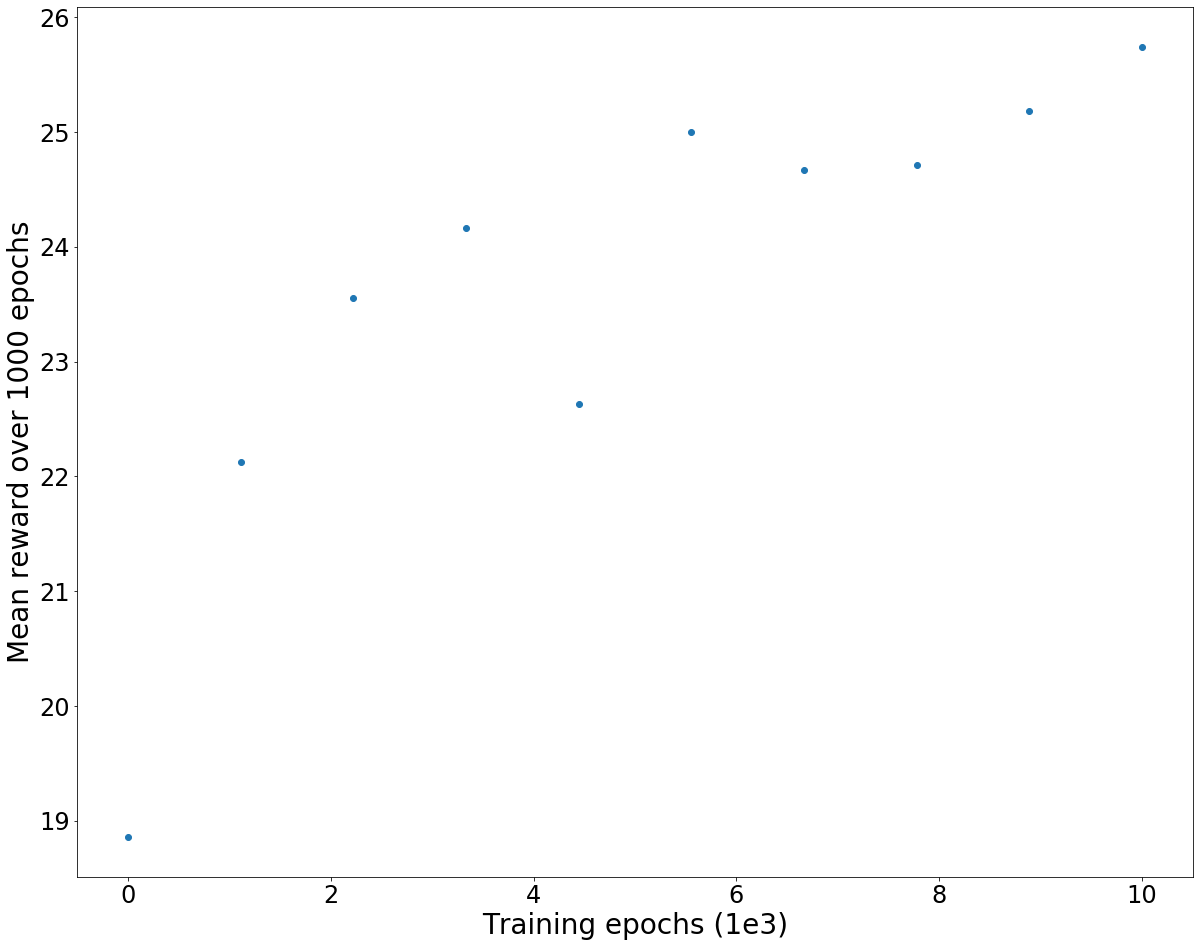

In [0]:
####################### -- Defining Parameters and Designing Experiement -- #########################
#investigating steps_, alpha and discount factor for 1,000,000 epochs of training 
# Model definitions: parameters, steps, tf, x0  
      
p        = {'u_m' : 0.0923*0.62, 'K_N' : 393.10, 'u_d' : 0.01, 'Y_nx' : 504.49}                 # model parameter definitions
steps_   = np.array([10])                                                                       # number of control interactions
tf       = 16.*24                                                 
x0       = np.array([0.5,150.0])                                                                # initial conditions of environment
modulus  = np.array([0.05, 10])                                                                 # line distance of state space
state_UB = np.array([5, 1000])                                                                  # state space upper bound

# Agent definitions: num_actions, eps_prob, alpha, discount
agent_name = 'MonteCarlo'
num_actions = 15                                                                                # number (range) of actions available to agent

disc1 = np.array([0.85])                                                                        # discount factor in back-allocation
disc2 = np.array([0.95])                                                                        # discount factor in agent learning
xi_ = np.array([3])                                                                             # Epsilon greedy definition (from experiment)

# Experiment defintions: env, agent, controls, episodes
controls          = np.linspace(0,7,num_actions)                                                         # defining range of controls
episodes_train    = 10000                                                                          # number of training epochs
episodes_valid    = 1000                                                                           # numeber of validation epochs
reward_training   = np.zeros((episodes_train, xi_.shape[0], disc1.shape[0], disc2.shape[0]))      # memory allocation 
reward_validation = np.zeros((episodes_valid, xi_.shape[0], disc1.shape[0], disc2.shape[0]))    # memory allocation 
bracket           = int(1000)

## These function are for plotting the output 
def EpochNoMean(data, bracket):
  nrows           = int(data.shape[0]/bracket)
  plot_prep_mean  = np.zeros((int(nrows)))
  for f in range(0,nrows):
    x = data[f*bracket:f*bracket+ bracket-1]
    y = np.mean(x,0)
    plot_prep_mean[f] = y
  return plot_prep_mean

#plot of 1000 epoch mean throughout training
def Plotting(data, nrows, bracket, pNo_mean, agent_name):
  plt.figure(figsize =(20,16))
  plt.scatter(np.linspace(0,len(data),nrows), data, label= 'Mean R over 1000 epochs')
  plt.xlabel('Training epochs (1e3)',  fontsize=28)
  plt.ylabel('Mean reward over ' + str(bracket)+ ' epochs', fontsize=28)
  plt.tick_params(labelsize=24)
  plt.savefig('insert your computer path here' + str(pNo_mean) + '_' + str(agent_name) +'.png')

# running experiement
env                 = Model_env(p, steps_, tf, x0, modulus)                                               # calling environment
agent               = greedye_MCL(num_actions, modulus, state_UB, disc1, disc2, steps_)                 # calling agent
experiment          = Experiment(env, agent, controls, episodes_train, xi_)                        # calling training experiment
reward_training, d  = experiment.simulation()                                              # running training experiment
agent               = Greedye_MCLearned(num_actions, d, steps_)                                         # calling learned agent
exp_done            = Experiment_Done(env, agent, controls, episodes_valid, 0)                       # calling validation experiment
reward_validation   = exp_done.simulation()                                                 # running validation experiment
reward_train_mean   = EpochNoMean(reward_training,bracket)
nrows               = int(len(reward_train_mean))
x_o                 = Plotting(reward_train_mean, nrows, bracket, "Time_allocation", agent_name )



Potential Challenges:

1) Can you install a policy of exploration from http://incompleteideas.net/book/bookdraft2017nov5.pdf (Sutton and Barto, 2017), Chapter 1. The policy of exploration we have implemented is an e-greedy policy but can we do better?
Exploration/Exploitation is a key problem within RL. Consider: how this implementation will affect the workflow of code; Is the policy defined within the agent's class methods or do we keep it within the environment? Alter the code to implement appropriately.

2) Detail the parameters, which govern the efficacy of learning. How do they influence the learning update? 

3) Code and implement a Q learning and SARSA agent instead of a Monte Carlo agent. Again, the algorithm/learning update is detailed in Sutton and Barto, above. 

4) The reward alllocation scheme we have implemented is far from optimal. Can you identify the reasons why? How may we improve the reward allocation scheme? Implement your improvements and quantify the improvements observed in learning. Note some reward allocations allow for online learning, think about how the code structure may change.

NB: Sutton and Barto are renowned for their contribution to RL. They are a good port of call for any learning or questions you may have. I found when I got stuck on these problems it was usually that I hadn't quite got the entire concept. Their writing is really clear and logical, try to spend some time understanding each chapter.

Another great source is David Silver's lecture series on RL at UCL. He is one of the people who developed the AlphaGo and AlphaZero algorithms at DeepMind. In parallel to this work, try to read a few articles on state of the art RL - they will expand your knowledge and perception of this work. I have recommended a few in the literature list.


